### SECTION 1:Inspection Initiale du Dataset
##### Chargement et premières lignes

In [ ]:
#valeurs manquantes

# s'assurer que pandas et df sont disponibles
if 'pd' not in globals():
	import pandas as pd

if 'df' not in globals():
	# charger le fichier si df n'existe pas encore
	df = pd.read_excel("morocco_ecommerce_anomalies.xlsx")
	df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

missing = df.isna().sum()
missing_percentage = df.isna().mean() * 100
print(missing, "\n", missing_percentage)


order_id               0
customer_id            0
order_date             0
ship_date            379
region               284
city                 269
payment_method       288
product_category       0
product_id             0
quantity              64
unit_price            64
total_amount           0
discount_code       1051
order_status           0
dtype: int64 
 order_id             0.000000
customer_id          0.000000
order_date           0.000000
ship_date            7.542289
region               5.651741
city                 5.353234
payment_method       5.731343
product_category     0.000000
product_id           0.000000
quantity             1.273632
unit_price           1.273632
total_amount         0.000000
discount_code       20.915423
order_status         0.000000
dtype: float64


##### Objectif : vérifier la structure, détecter visuellement des anomalies (espaces, erreurs de type).

#### Décisions business

##### Critique : order_id, order_date, total_amount, quantity, unit_price.
##### Semi-critique : city, region.
##### Optionnel : discount_code, comments.

#### Stratégie :

##### Critique → drop ou imputation prudente si possible.
##### Semi-critique → imputation ou standardisation (Unknown).
##### Optionnel → laisser NaN.

#### SECTION 3 : Correction des types et valeurs corrompues
##### Quantité et prix

In [ ]:
# Nettoyage "quantity"
df['quantity'] = pd.to_numeric(df['quantity'].replace({"two":2, "free":0}), errors='coerce')

# Nettoyage "unit_price"
df['unit_price'] = pd.to_numeric(df['unit_price'].replace({"free":0}), errors='coerce')

# après conversion
df[['quantity','unit_price']].describe()

# valeurs non convertibles deviennent NaN → traitement ultérieur.
0

,quantity,unit_price
count,4938.000000,4932.000000
mean,4.104293,725.441713
std,11.862757,3405.720823
min,1.000000,0.000000
25%,2.000000,294.707500
50%,3.000000,402.605000
75%,4.000000,512.525000
max,199.000000,49316.000000


In [12]:
#le nombre de lignes et colonnes.
print("Shape:", df.shape)


Shape: (5025, 14)


In [13]:
 # Types de données
print(df.dtypes)

order_id             object
customer_id          object
order_date           object
ship_date            object
region               object
city                 object
payment_method       object
product_category     object
product_id           object
quantity             object
unit_price           object
total_amount        float64
discount_code        object
order_status         object
dtype: object


### SECTION 4:Nettoyage des champs catégoriels
##### Normalisation des villes et régions

In [1]:
# s'assurer que openpyxl est disponible pour lire le fichier Excel et importer pandas
%pip install openpyxl
import pandas as pd

# Load data if not already loaded
if 'df' not in locals():
    df = pd.read_excel("morocco_ecommerce_anomalies.xlsx", engine="openpyxl")
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# éviter la duplication dans les groupby et analyses.

df['city'] = df['city'].str.strip().str.title().replace({
    "Casa":"Casablanca",
    "casa":"Casablanca",
    "CASA":"Casablanca"
})

df['region'] = df['region'].str.strip().str.title()

# Affichage des résultats du nettoyage
print("=" * 60)
print("NETTOYAGE DES VILLES ET RÉGIONS")
print("=" * 60)

print("\n Villes uniques après nettoyage :")
print(f"Nombre total : {df['city'].nunique()}")
print(df['city'].value_counts())

print("\n" + "=" * 60)
print("\n Régions uniques après nettoyage :")
print(f"Nombre total : {df['region'].nunique()}")
print(df['region'].value_counts())

print("\n" + "=" * 60)
print("\n Aperçu des données nettoyées :")
print(df[['city', 'region']].head(10))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
NETTOYAGE DES VILLES ET RÉGIONS

 Villes uniques après nettoyage :
Nombre total : 29
city
Dakhla         420
Guelmim        386
Laâyoune       358
Meknès         205
Khénifra       202
Ouarzazate     192
Béni Mellal    191
Errachidia     191
Fès            161
Nador          149
Tanger         142
Al Hoceïma     141
Safi           140
Tétouan        139
Marrakech      139
Oujda          137
Berkane        135
Rabat          135
Salé           133
Chichaoua      133
Casablanca     126
Tiznit         124
Settat         124
Agadir         121
Kénitra        120
Mohammedia     110
Inezgane       103
El Jadida       86
Nan             13
Name: count, dtype: int64


 Régions uniques après nettoyage :
Nombre total : 23
region
Casabla

### SECTION 5: Nettoyage des dates
##### Conversion et validation

In [4]:
#Les dates invalides deviennent NaT → décider de drop ou imputation.
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['ship_date'] = pd.to_datetime(df['ship_date'], errors='coerce')

# Colonnes année, mois, jour de la semaine
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['weekday'] = df['order_date'].dt.day_name()

# Affichage / diagnostic des conversions de dates
print("=" * 60)
print("DIAGNOSTIC - CONVERSION DES DATES")
print("=" * 60)

total = len(df)
if total == 0:
    print("Le DataFrame est vide.")
else:
    n_order_nat = df['order_date'].isna().sum()
    n_ship_nat = df['ship_date'].isna().sum()
    print(f"Total de lignes : {total}")
    print(f"order_date NaT : {n_order_nat} ({n_order_nat/total:.2%})")
    print(f"ship_date NaT  : {n_ship_nat} ({n_ship_nat/total:.2%})")
    print()
    print("Exemples des premières lignes (order_date, ship_date) :")
    display(df[['order_date', 'ship_date']].head(10))
    print()
    try:
        print(f"Première date order_date : {df['order_date'].min()}")
        print(f"Dernière date order_date  : {df['order_date'].max()}")
    except Exception:
        pass
    print()
    print("Distribution par année :")
    print(df['year'].value_counts(dropna=True).sort_index())
    print()
    print("Distribution par mois (1-12) :")
    print(df['month'].value_counts().sort_index())
    print()
    print("Distribution par jour de la semaine :")
    print(df['weekday'].value_counts())

print("=" * 60)


DIAGNOSTIC - CONVERSION DES DATES
Total de lignes : 5025
order_date NaT : 497 (9.89%)
ship_date NaT  : 379 (7.54%)

Exemples des premières lignes (order_date, ship_date) :


,order_date,ship_date
0,2023-03-14,2023-03-17
1,2023-01-13,2023-01-15
2,2023-08-17,2023-08-22
3,2023-09-06,2023-09-13
4,2023-10-09,NaT
5,NaT,2023-12-20
6,2023-07-01,2023-07-08
7,2023-10-29,2023-10-30
8,2023-09-18,2023-09-28
9,2023-04-11,2023-04-11



Première date order_date : 2023-01-01 00:00:00
Dernière date order_date  : 2023-12-30 00:00:00

Distribution par année :
year
2023.0    4528
Name: count, dtype: int64

Distribution par mois (1-12) :
month
1.0     389
2.0     350
3.0     403
4.0     406
5.0     341
6.0     400
7.0     409
8.0     382
9.0     383
10.0    373
11.0    356
12.0    336
Name: count, dtype: int64

Distribution par jour de la semaine :
weekday
Thursday     674
Tuesday      669
Wednesday    658
Saturday     651
Friday       646
Monday       637
Sunday       593
Name: count, dtype: int64


### SECTION 6: Détection des doublons
##### Suppression des doublons

In [5]:
# dataset nettoyé de doublons totaux et par identifiant de commande.
print("=" * 60)
print("DÉTECTION DES DOUBLONS - AVANT / APRÈS")
print("=" * 60)

# Comptes initiaux
n_rows_before = len(df)
n_full_duplicates_before = df.duplicated().sum()
n_order_duplicates_before = df.duplicated(subset='order_id').sum()

print(f"Lignes au départ : {n_rows_before}")
print(f"Doublons complets (lignes identiques) : {n_full_duplicates_before} ({n_full_duplicates_before / n_rows_before:.2%} si >0)")
print(f"Doublons par 'order_id' : {n_order_duplicates_before} ({n_order_duplicates_before / n_rows_before:.2%} si >0)")

# Exemples pour inspecter
if n_full_duplicates_before > 0:
    print("\nExemples de lignes complètement dupliquées :")
    display(df[df.duplicated(keep=False)].head(10))
else:
    print("\nAucun doublon complet détecté.")

if n_order_duplicates_before > 0:
    print("\nExemples d'order_id présents plusieurs fois (regroupés) :")
    dup_orders = df[df.duplicated(subset='order_id', keep=False)].sort_values('order_id')
    display(dup_orders.head(12))
else:
    print("\nAucun order_id dupliqué détecté.")

# Choix de déduplication :
# 1) Supprimer doublons complets (lignes identiques)
# 2) Supprimer doublons par 'order_id', en gardant la première occurrence

# 1) Drop doublons complets
print("\n--- Suppression des doublons complets (lignes identiques) ---")
rows_before_step1 = len(df)
df = df.drop_duplicates()
rows_after_step1 = len(df)
print(f"Lignes avant : {rows_before_step1}, après : {rows_after_step1}, supprimées : {rows_before_step1 - rows_after_step1}")

# 2) Drop doublons par order_id
print("\n--- Suppression des doublons par 'order_id' (garder la première occurrence) ---")
rows_before_step2 = len(df)
df = df.drop_duplicates(subset='order_id', keep='first')
rows_after_step2 = len(df)
print(f"Lignes avant : {rows_before_step2}, après : {rows_after_step2}, supprimées : {rows_before_step2 - rows_after_step2}")

# Vérification finale
n_full_duplicates_after = df.duplicated().sum()
n_order_duplicates_after = df.duplicated(subset='order_id').sum()
print("\nVérification finale :")
print(f"Doublons complets restants : {n_full_duplicates_after}")
print(f"Doublons par order_id restants : {n_order_duplicates_after}")

print("\nAperçu post-nettoyage (5 premières lignes) :")
display(df.head())
print("=" * 60)


DÉTECTION DES DOUBLONS - AVANT / APRÈS
Lignes au départ : 5025
Doublons complets (lignes identiques) : 119 (2.37% si >0)
Doublons par 'order_id' : 222 (4.42% si >0)

Exemples de lignes complètement dupliquées :


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday
29,ORD000602,CUS01558,2023-12-30,2024-01-05,Marrakech-Safi,Marrakech,Credit Card,Beauty,P00024,5,369.19,1845.95,WELCOME,Cancelled,2023.0,12.0,Saturday
80,ORD000081,CUS01880,2023-04-26,2023-04-27,Souss-Massa,Tiznit,Mobile Payment,Beauty,P00805,5,573.11,2865.55,SALE20,Cancelled,2023.0,4.0,Wednesday
94,ORD004903,CUS01243,2023-04-14,2023-04-21,NaN,Khénifra,NaN,Electronics,P00621,1,361.97,361.97,NaN,Returned,2023.0,4.0,Friday
156,ORD000157,CUS00253,2023-12-05,2023-12-06,NaN,Nador,NaN,Fashion,P00199,3,346.46,1039.38,NaN,Delivered,2023.0,12.0,Tuesday
165,ORD000166,CUS01628,2023-01-28,2023-02-01,Rabat-Salé-Kénitra,Salé,Mobile Payment,Sports,P00874,4,567.73,2270.92,NaN,Delivered,2023.0,1.0,Saturday
177,ORD000178,CUS00323,2023-06-14,2023-06-24,Drâa-Tafilalet,Errachidia,Credit Card,Home & Kitchen,P00385,1,815.64,815.64,FREESHIP,Cancelled,2023.0,6.0,Wednesday
200,ORD000157,CUS00253,2023-12-05,2023-12-06,NaN,Nador,NaN,Fashion,P00199,3,346.46,1039.38,NaN,Delivered,2023.0,12.0,Tuesday
232,ORD000537,CUS00911,2023-01-21,2023-01-22,Fès-Meknès,Meknès,Bank Transfer,Sports,P00704,1,770.0,770.00,WELCOME,Delivered,2023.0,1.0,Saturday
238,ORD003148,CUS01673,2023-03-05,2023-03-11,Oriental,Oujda,Credit Card,Books,P00509,2,98.91,197.82,RAMADAN10,Cancelled,2023.0,3.0,Sunday
252,ORD000178,CUS00323,2023-06-14,2023-06-24,Drâa-Tafilalet,Errachidia,Credit Card,Home & Kitchen,P00385,1,815.64,815.64,FREESHIP,Cancelled,2023.0,6.0,Wednesday



Exemples d'order_id présents plusieurs fois (regroupés) :


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday
5,ORD000006,CUS01717,NaT,2023-12-20,Marrakech-Safi,Marrakech,Mobile Payment,Books,P00885,4,135.49,541.96,NaN,Delivered,NaN,NaN,NaN
4346,ORD000006,CUS01717,2023-12-12,2023-12-20,Marrakech Safi,Marrakech,Mobile Payment,Books,P00885,4,135.49,541.96,NaN,Delivered,2023.0,12.0,Tuesday
33,ORD000034,CUS01109,2023-02-23,2023-02-28,Laâyoune-Sakia El Hamra,Laâyoune,Credit Card,Home & Kitchen,P00490,5,20.0,100.00,NaN,Cancelled,2023.0,2.0,Thursday
1442,ORD000034,CUS01109,NaT,2023-02-28,Laâyoune-Sakia El Hamra,Laâyoune,Credit Card,Home & Kitchen,P00490,5,20.0,100.00,NaN,Cancelled,NaN,NaN,NaN
80,ORD000081,CUS01880,2023-04-26,2023-04-27,Souss-Massa,Tiznit,Mobile Payment,Beauty,P00805,5,573.11,2865.55,SALE20,Cancelled,2023.0,4.0,Wednesday
2814,ORD000081,CUS01880,2023-04-26,2023-04-27,Souss-Massa,Tiznit,Mobile Payment,Beauty,P00805,5,573.11,2865.55,SALE20,Cancelled,2023.0,4.0,Wednesday
4980,ORD000081,CUS01880,2023-04-26,NaT,Souss-Massa,Tiznit,Mobile Payment,Beauty,P00805,5,573.11,2865.55,SALE20,Cancelled,2023.0,4.0,Wednesday
99,ORD000100,CUS00280,2023-04-18,2023-04-28,Casablanca-Settat,Casablanca,Mobile Payment,Home & Kitchen,P00729,5,465.66,2328.30,WELCOME,Cancelled,2023.0,4.0,Tuesday
3287,ORD000100,CUS00280,2023-04-18,2023-04-28,Casablanca-Settat,Casablanca,Mobile Payment,Home & Kitchen,P00729,1,465.66,465.66,WELCOME,Cancelled,2023.0,4.0,Tuesday
118,ORD000119,CUS00491,2023-11-14,2023-11-19,NaN,Meknès,Bank Transfer,Books,P00113,4,563.73,2254.92,FREESHIP,Returned,2023.0,11.0,Tuesday



--- Suppression des doublons complets (lignes identiques) ---
Lignes avant : 5025, après : 4906, supprimées : 119

--- Suppression des doublons par 'order_id' (garder la première occurrence) ---
Lignes avant : 4906, après : 4803, supprimées : 103

Vérification finale :
Doublons complets restants : 0
Doublons par order_id restants : 0

Aperçu post-nettoyage (5 premières lignes) :


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday
0,ORD000001,CUS00179,2023-03-14,2023-03-17,Casablanca-Settat,Casablanca,Credit Card,electronics,P00778,NaN,free,1315.19,SALE20,Returned,2023.0,3.0,Tuesday
1,ORD000002,CUS01548,2023-01-13,2023-01-15,Béni Mellal-Khénifra,Khénifra,Bank Transfer,Home & Kitchen,P00081,3,417.67,1253.01,FREESHIP,Shipped,2023.0,1.0,Friday
2,ORD000003,CUS01309,2023-08-17,2023-08-22,Béni Mellal-Khénifra,Béni Mellal,Bank Transfer,Home & Kitchen,P00215,2,384.54,769.08,WELCOME,Returned,2023.0,8.0,Thursday
3,ORD000004,CUS00878,2023-09-06,2023-09-13,Oriental,Berkane,Bank Transfer,Sports,P00565,4,206.38,825.52,NaN,Returned,2023.0,9.0,Wednesday
4,ORD000005,CUS00866,2023-10-09,NaT,Béni Mellal-Khénifra,Khénifra,Credit Card,Fashion,P00923,1,426.41,426.41,NaN,Processing,2023.0,10.0,Monday


### SECTION 7: Détection et traitement 
##### Méthode IQR et Z-score

DIAGNOSTIC - OUTLIERS (IQR & Z-SCORE)
Seuils IQR : lower = -1193.59 ; upper = 3555.64
Total de lignes : 4803
Outliers selon IQR : 162 (3.37%)
Outliers selon Z-score (|z|>3) : 14 (0.29%)
Outliers détectés par les deux méthodes : 14

Exemples d'outliers IQR (10 premiers) :


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday
130,ORD000131,CUS01131,2023-04-28,2023-05-01,Dakhla-Oued Ed-Dahab,Dakhla,Bank Transfer,Home & Kitchen,P00243,4,655.43,4931600.0,NaN,Processing,2023.0,4.0,Friday
270,ORD000271,CUS00590,2023-03-09,2023-03-19,Oriental,Berkane,Credit Card,Fashion,P00779,3,417.98,4931600.0,RAMADAN10,Returned,2023.0,3.0,Thursday
884,ORD000885,CUS01626,2023-02-17,2023-02-18,Casablanca-Settat,Settat,Cash on Delivery,Beauty,P00331,5,541.48,4931600.0,WELCOME,Returned,2023.0,2.0,Friday
409,ORD000410,CUS00028,2023-09-16,2023-09-17,Souss-Massa,Agadir,Mobile Payment,Sports,P00305,1,632.7,4931600.0,SALE20,Shipped,2023.0,9.0,Saturday
554,ORD000555,CUS01968,2023-07-21,2023-07-31,Souss-Massa,Inezgane,Bank Transfer,Fashion,P00906,4,717.98,4931600.0,AYD10,Shipped,2023.0,7.0,Friday
4926,ORD004927,CUS00798,2023-07-27,2023-08-02,Rabat-Salé-Kénitra,Kénitra,Credit Card,Electronics,P00904,5,226.24,4931600.0,WELCOME,Returned,2023.0,7.0,Thursday
4646,ORD004647,CUS01491,2023-05-17,2023-05-27,NaN,Nador,Bank Transfer,Sports,P00005,5,402.33,4931600.0,WELCOME,Processing,2023.0,5.0,Wednesday
2550,ORD002551,CUS01309,2023-05-10,2023-05-14,Casablanca-Settat,Mohammedia,Mobile Payment,Books,P00339,1,570.33,4931600.0,SALE20,Returned,2023.0,5.0,Wednesday
2255,ORD002256,CUS01372,2023-09-02,2023-09-02,Laâyoune-Sakia El Hamra,Laâyoune,Credit Card,Beauty,P00828,2,493.03,4931600.0,AYD10,Processing,2023.0,9.0,Saturday
4494,ORD004495,CUS00615,2023-08-01,2023-08-01,Dakhla-Oued Ed-Dahab,Dakhla,Cash on Delivery,Beauty,P00832,1,311.46,4931600.0,NaN,Shipped,2023.0,8.0,Tuesday



Exemples d'outliers Z-score (10 premiers) :


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday,z_total
130,ORD000131,CUS01131,2023-04-28,2023-05-01,Dakhla-Oued Ed-Dahab,Dakhla,Bank Transfer,Home & Kitchen,P00243,4,655.43,4931600.0,NaN,Processing,2023.0,4.0,Friday,18.475795
270,ORD000271,CUS00590,2023-03-09,2023-03-19,Oriental,Berkane,Credit Card,Fashion,P00779,3,417.98,4931600.0,RAMADAN10,Returned,2023.0,3.0,Thursday,18.475795
409,ORD000410,CUS00028,2023-09-16,2023-09-17,Souss-Massa,Agadir,Mobile Payment,Sports,P00305,1,632.7,4931600.0,SALE20,Shipped,2023.0,9.0,Saturday,18.475795
554,ORD000555,CUS01968,2023-07-21,2023-07-31,Souss-Massa,Inezgane,Bank Transfer,Fashion,P00906,4,717.98,4931600.0,AYD10,Shipped,2023.0,7.0,Friday,18.475795
884,ORD000885,CUS01626,2023-02-17,2023-02-18,Casablanca-Settat,Settat,Cash on Delivery,Beauty,P00331,5,541.48,4931600.0,WELCOME,Returned,2023.0,2.0,Friday,18.475795
1741,ORD001742,CUS01487,2023-11-21,2023-11-28,Souss-Massa,Tiznit,Cash on Delivery,Electronics,P00942,3,217.31,4931600.0,AYD10,Delivered,2023.0,11.0,Tuesday,18.475795
2255,ORD002256,CUS01372,2023-09-02,2023-09-02,Laâyoune-Sakia El Hamra,Laâyoune,Credit Card,Beauty,P00828,2,493.03,4931600.0,AYD10,Processing,2023.0,9.0,Saturday,18.475795
2550,ORD002551,CUS01309,2023-05-10,2023-05-14,Casablanca-Settat,Mohammedia,Mobile Payment,Books,P00339,1,570.33,4931600.0,SALE20,Returned,2023.0,5.0,Wednesday,18.475795
3784,ORD003785,CUS01969,2023-04-07,2023-04-17,Fès-Meknès,Fès,Bank Transfer,Fashion,P00965,2,326.14,4931600.0,FREESHIP,Delivered,2023.0,4.0,Friday,18.475795
4494,ORD004495,CUS00615,2023-08-01,2023-08-01,Dakhla-Oued Ed-Dahab,Dakhla,Cash on Delivery,Beauty,P00832,1,311.46,4931600.0,NaN,Shipped,2023.0,8.0,Tuesday,18.475795



Statistiques descriptives des outliers (IQR) sur total_amount :
count    1.620000e+02
mean     4.681178e+05
std      1.378009e+06
min      3.572950e+03
25%      5.929750e+03
50%      3.489211e+04
75%      7.285717e+04
max      4.931600e+06
Name: total_amount, dtype: float64

Top 10 commandes par montant :


,order_id,total_amount,city,region
3784,ORD003785,4931600.0,Fès,Fès-Meknès
2550,ORD002551,4931600.0,Mohammedia,Casablanca-Settat
4926,ORD004927,4931600.0,Kénitra,Rabat-Salé-Kénitra
4494,ORD004495,4931600.0,Dakhla,Dakhla-Oued Ed-Dahab
409,ORD000410,4931600.0,Agadir,Souss-Massa
884,ORD000885,4931600.0,Settat,Casablanca-Settat
554,ORD000555,4931600.0,Inezgane,Souss-Massa
1741,ORD001742,4931600.0,Tiznit,Souss-Massa
4646,ORD004647,4931600.0,Nador,NaN
270,ORD000271,4931600.0,Berkane,Oriental


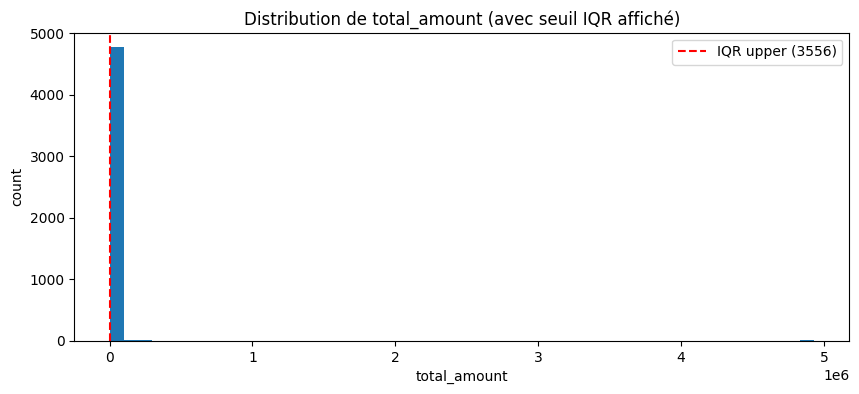

In [6]:
Q1 = df['total_amount'].quantile(0.25)
Q3 = df['total_amount'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers_iqr = df[(df['total_amount'] < lower) | (df['total_amount'] > upper)]

# Z-score
from scipy.stats import zscore
# zscore sur total_amount en remplaçant NaN par 0 pour le calcul (mais garder NaN comme NaN dans df)
df['z_total'] = zscore(df['total_amount'].fillna(0))
outliers_z = df[df['z_total'].abs() > 3]

# Décision : flag plutôt que drop (ici on flag selon le seuil upper)
df['total_amount_outlier'] = df['total_amount'].apply(lambda x: 1 if pd.notna(x) and x > upper else 0)

# Affichage / diagnostic des outliers
print("=" * 80)
print("DIAGNOSTIC - OUTLIERS (IQR & Z-SCORE)")
print("=" * 80)

print(f"Seuils IQR : lower = {lower:.2f} ; upper = {upper:.2f}")

total = len(df)
ni = len(outliers_iqr)
nz = len(outliers_z)
print(f"Total de lignes : {total}")
print(f"Outliers selon IQR : {ni} ({ni/total:.2%})")
print(f"Outliers selon Z-score (|z|>3) : {nz} ({nz/total:.2%})")

# Intersection
common_idx = outliers_iqr.index.intersection(outliers_z.index)
n_common = len(common_idx)
print(f"Outliers détectés par les deux méthodes : {n_common if (n_common := n_common if 'n_common' in locals() else None) is None else n_common}")
# Note: above line uses a compact pattern to show number; if environment does not support walrus, fallback below
if 'n_common' not in locals():
    print(f"Outliers détectés par les deux méthodes : {n_common}")

print('\nExemples d\'outliers IQR (10 premiers) :')
if ni > 0:
    display(outliers_iqr.sort_values('total_amount', ascending=False).head(10))
else:
    print('Aucun outlier IQR détecté.')

print('\nExemples d\'outliers Z-score (10 premiers) :')
if nz > 0:
    display(outliers_z.sort_values('z_total', key=lambda s: s.abs(), ascending=False).head(10))
else:
    print('Aucun outlier Z-score détecté.')

# Statistiques descriptives des outliers IQR
if ni > 0:
    print('\nStatistiques descriptives des outliers (IQR) sur total_amount :')
    print(outliers_iqr['total_amount'].describe())

# Top 10 commandes par montant (peut inclure outliers)
print('\nTop 10 commandes par montant :')
if df['total_amount'].notna().sum() > 0:
    display(df[['order_id','total_amount','city','region']].sort_values('total_amount', ascending=False).head(10))
else:
    print('Aucun total_amount valide trouvé.')

# Histogramme rapide pour visualiser la distribution
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,4))
    plt.hist(df['total_amount'].dropna(), bins=50)
    plt.axvline(upper, color='red', linestyle='--', label=f'IQR upper ({upper:.0f})')
    plt.title('Distribution de total_amount (avec seuil IQR affiché)')
    plt.xlabel('total_amount')
    plt.ylabel('count')
    plt.legend()
    plt.show()
except Exception:
    pass

print("=" * 80)


### SECTION 8 : Filtrage & sous-ensembles

In [8]:
# S'assurer que 'quantity' est bien numérique
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')

df_qty_gt3 = df[df['quantity'] > 3]
df_total_gt1000 = df[df['total_amount'] > 1000]
df_casa_region = df[df['region'] == "Casablanca-Settat"]
df_non_cod = df[df['payment_method'] != "Cash on Delivery"]
df_recent_orders = df[df['order_date'] > "2023-06-01"]

# Affichage diagnostics pour chaque sous-ensemble
print('=' * 60)
print('SOUS-ENSEMBLES FILTRÉS - DIAGNOSTIC')
print('=' * 60)

def _diag(subdf, name):
    total = len(df) if len(df) > 0 else 1
    print(f"\n-- {name} --")
    print(f"Nombre de lignes : {len(subdf)} ({len(subdf)/total:.2%})")
    if 'total_amount' in subdf.columns and subdf['total_amount'].notna().sum() > 0:
        print('total_amount → count / mean / median / sum :')
        print(subdf['total_amount'].agg(['count','mean','median','sum']).to_string())
    print('\nAperçu (5 premières lignes) :')
    display(subdf.head())

_diag(df_qty_gt3, 'Quantité > 3')
_diag(df_total_gt1000, 'Total_amount > 1000')
_diag(df_casa_region, 'Région Casablanca-Settat')
_diag(df_non_cod, "Méthode paiement ≠ Cash on Delivery")

# Diagnostic spécifique pour les commandes récentes
print('\n-- Commandes récentes (> 2023-06-01) --')
print(f"Nombre : {len(df_recent_orders)} ({len(df_recent_orders)/len(df):.2%} du dataset)")
if len(df_recent_orders) > 0:
    print(f"Date min : {df_recent_orders['order_date'].min()}  |  Date max : {df_recent_orders['order_date'].max()}")
    display(df_recent_orders.head())

print('\n' + '=' * 60)


SOUS-ENSEMBLES FILTRÉS - DIAGNOSTIC

-- Quantité > 3 --
Nombre de lignes : 1926 (40.10%)
total_amount → count / mean / median / sum :
count     1.926000e+03
mean      2.233356e+04
median    1.827300e+03
sum       4.301444e+07

Aperçu (5 premières lignes) :


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday,z_total,total_amount_outlier
3,ORD000004,CUS00878,2023-09-06,2023-09-13,Oriental,Berkane,Bank Transfer,Sports,P00565,4.0,206.38,825.52,NaN,Returned,2023.0,9.0,Wednesday,-0.060618,0
5,ORD000006,CUS01717,NaT,2023-12-20,Marrakech-Safi,Marrakech,Mobile Payment,Books,P00885,4.0,135.49,541.96,NaN,Delivered,NaN,NaN,NaN,-0.061684,0
6,ORD000007,CUS00172,2023-07-01,2023-07-08,Tanger-Tétouan-Al Hoceïma,Tétouan,Credit Card,Home & Kitchen,P00935,4.0,299.21,1196.84,AYD10,Processing,2023.0,7.0,Saturday,-0.059222,0
8,ORD000009,CUS00403,2023-09-18,2023-09-28,Dakhla-Oued Ed-Dahab,Dakhla,NaN,Books,P00800,4.0,578.45,2313.80,WELCOME,Cancelled,2023.0,9.0,Monday,-0.055023,0
9,ORD000010,CUS00189,2023-04-11,2023-04-11,Béni Mellal-Khénifra,Khénifra,Cash on Delivery,Beauty,P00364,4.0,752.41,3009.64,SALE20,Delivered,2023.0,4.0,Tuesday,-0.052407,0



-- Total_amount > 1000 --
Nombre de lignes : 2662 (55.42%)
total_amount → count / mean / median / sum :
count     2.662000e+03
mean      3.013329e+04
median    1.688400e+03
sum       8.021483e+07

Aperçu (5 premières lignes) :


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday,z_total,total_amount_outlier
0,ORD000001,CUS00179,2023-03-14,2023-03-17,Casablanca-Settat,Casablanca,Credit Card,electronics,P00778,NaN,free,1315.19,SALE20,Returned,2023.0,3.0,Tuesday,-0.058777,0
1,ORD000002,CUS01548,2023-01-13,2023-01-15,Béni Mellal-Khénifra,Khénifra,Bank Transfer,Home & Kitchen,P00081,3.0,417.67,1253.01,FREESHIP,Shipped,2023.0,1.0,Friday,-0.059011,0
6,ORD000007,CUS00172,2023-07-01,2023-07-08,Tanger-Tétouan-Al Hoceïma,Tétouan,Credit Card,Home & Kitchen,P00935,4.0,299.21,1196.84,AYD10,Processing,2023.0,7.0,Saturday,-0.059222,0
8,ORD000009,CUS00403,2023-09-18,2023-09-28,Dakhla-Oued Ed-Dahab,Dakhla,NaN,Books,P00800,4.0,578.45,2313.80,WELCOME,Cancelled,2023.0,9.0,Monday,-0.055023,0
9,ORD000010,CUS00189,2023-04-11,2023-04-11,Béni Mellal-Khénifra,Khénifra,Cash on Delivery,Beauty,P00364,4.0,752.41,3009.64,SALE20,Delivered,2023.0,4.0,Tuesday,-0.052407,0



-- Région Casablanca-Settat --
Nombre de lignes : 414 (8.62%)
total_amount → count / mean / median / sum :
count     4.140000e+02
mean      2.582166e+04
median    9.852800e+02
sum       1.069017e+07

Aperçu (5 premières lignes) :


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday,z_total,total_amount_outlier
0,ORD000001,CUS00179,2023-03-14,2023-03-17,Casablanca-Settat,Casablanca,Credit Card,electronics,P00778,NaN,free,1315.19,SALE20,Returned,2023.0,3.0,Tuesday,-0.058777,0
32,ORD000033,CUS00185,2023-05-12,2023-05-21,Casablanca-Settat,Mohammedia,Credit Card,Books,P00640,2.0,449.73,899.46,NaN,Shipped,2023.0,5.0,Friday,-0.060340,0
39,ORD000040,CUS01263,2023-03-20,2023-03-24,Casablanca-Settat,El Jadida,Mobile Payment,Sports,P00696,3.0,552.81,1658.43,FREESHIP,Processing,2023.0,3.0,Monday,-0.057486,0
41,ORD000042,CUS01516,NaT,2023-03-11,Casablanca-Settat,El Jadida,Mobile Payment,Beauty,P00429,1.0,196,196.00,NaN,Delivered,NaN,NaN,NaN,-0.062984,0
44,ORD000045,CUS00136,2023-10-22,NaT,Casablanca-Settat,Mohammedia,Bank Transfer,Sports,P00533,2.0,487.67,975.34,RAMADAN10,Delivered,2023.0,10.0,Sunday,-0.060054,0



-- Méthode paiement ≠ Cash on Delivery --
Nombre de lignes : 3707 (77.18%)
total_amount → count / mean / median / sum :
count     3.707000e+03
mean      1.591129e+04
median    1.109550e+03
sum       5.898315e+07

Aperçu (5 premières lignes) :


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday,z_total,total_amount_outlier
0,ORD000001,CUS00179,2023-03-14,2023-03-17,Casablanca-Settat,Casablanca,Credit Card,electronics,P00778,NaN,free,1315.19,SALE20,Returned,2023.0,3.0,Tuesday,-0.058777,0
1,ORD000002,CUS01548,2023-01-13,2023-01-15,Béni Mellal-Khénifra,Khénifra,Bank Transfer,Home & Kitchen,P00081,3.0,417.67,1253.01,FREESHIP,Shipped,2023.0,1.0,Friday,-0.059011,0
2,ORD000003,CUS01309,2023-08-17,2023-08-22,Béni Mellal-Khénifra,Béni Mellal,Bank Transfer,Home & Kitchen,P00215,2.0,384.54,769.08,WELCOME,Returned,2023.0,8.0,Thursday,-0.060830,0
3,ORD000004,CUS00878,2023-09-06,2023-09-13,Oriental,Berkane,Bank Transfer,Sports,P00565,4.0,206.38,825.52,NaN,Returned,2023.0,9.0,Wednesday,-0.060618,0
4,ORD000005,CUS00866,2023-10-09,NaT,Béni Mellal-Khénifra,Khénifra,Credit Card,Fashion,P00923,1.0,426.41,426.41,NaN,Processing,2023.0,10.0,Monday,-0.062118,0



-- Commandes récentes (> 2023-06-01) --
Nombre : 2514 (52.34% du dataset)
Date min : 2023-06-02 00:00:00  |  Date max : 2023-12-30 00:00:00


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status,year,month,weekday,z_total,total_amount_outlier
2,ORD000003,CUS01309,2023-08-17,2023-08-22,Béni Mellal-Khénifra,Béni Mellal,Bank Transfer,Home & Kitchen,P00215,2.0,384.54,769.08,WELCOME,Returned,2023.0,8.0,Thursday,-0.060830,0
3,ORD000004,CUS00878,2023-09-06,2023-09-13,Oriental,Berkane,Bank Transfer,Sports,P00565,4.0,206.38,825.52,NaN,Returned,2023.0,9.0,Wednesday,-0.060618,0
4,ORD000005,CUS00866,2023-10-09,NaT,Béni Mellal-Khénifra,Khénifra,Credit Card,Fashion,P00923,1.0,426.41,426.41,NaN,Processing,2023.0,10.0,Monday,-0.062118,0
6,ORD000007,CUS00172,2023-07-01,2023-07-08,Tanger-Tétouan-Al Hoceïma,Tétouan,Credit Card,Home & Kitchen,P00935,4.0,299.21,1196.84,AYD10,Processing,2023.0,7.0,Saturday,-0.059222,0
7,ORD000008,CUS01395,2023-10-29,2023-10-30,Souss-Massa,Agadir,Cash on Delivery,Sports,P00987,1.0,473.38,473.38,RAMADAN10,Processing,2023.0,10.0,Sunday,-0.061941,0


### SECTION 9: Analyse groupée & KPIs
##### Agrégations clés

In [9]:
# Statistiques globales
# S'assurer que total_amount est numérique
df['total_amount'] = pd.to_numeric(df['total_amount'], errors='coerce')

global_stats = df['total_amount'].agg(['count','mean','median','min','max','sum'])
print("=" * 60)
print("STATISTIQUES GLOBALES - total_amount")
print(global_stats.to_string())
print("=" * 60)

# Par région
if 'region' in df.columns:
    region_stats = df.groupby('region')['total_amount'].agg(['sum','mean','count']).sort_values('sum', ascending=False)
    print("\nTop régions par chiffre d'affaires (sum) :")
    display(region_stats.head(10))
else:
    region_stats = pd.DataFrame()
    print("Colonne 'region' absente.")

# Par catégorie produit
if 'product_category' in df.columns:
    category_stats = df.groupby('product_category')['total_amount'].agg(['sum','mean','count']).sort_values('sum', ascending=False)
    print("\nTop catégories par chiffre d'affaires :")
    display(category_stats.head(10))
else:
    category_stats = pd.DataFrame()
    print("Colonne 'product_category' absente.")

# Top 5 produits par revenue
if 'product_id' in df.columns:
    top_products = df.groupby('product_id')['total_amount'].sum().sort_values(ascending=False).head(5)
    print("\nTop 5 produits par revenue :")
    display(top_products)
else:
    top_products = pd.Series()
    print("Colonne 'product_id' absente.")

# Région avec la meilleure valeur moyenne
try:
    if not region_stats.empty:
        best_avg_region = region_stats['mean'].idxmax()
        print(f"\nRégion avec la meilleure valeur moyenne des commandes : {best_avg_region}")
    else:
        print("\nImpossible de déterminer la meilleure région (données manquantes).")
except Exception as e:
    print(f"Erreur lors du calcul de la meilleure région : {e}")

print("\nFin des KPIs principaux.")
print("=" * 60)


STATISTIQUES GLOBALES - total_amount
count     4.803000e+03
mean      1.695009e+04
median    1.104140e+03
min       2.000000e+01
max       4.931600e+06
sum       8.141129e+07

Top régions par chiffre d'affaires (sum) :


,sum,mean,count
region,,,
Souss-Massa,16165805.72,51157.613038,316
Dakhla-Oued Ed-Dahab,10925200.40,27870.409184,392
Rabat-Salé-Kénitra,10728907.46,32026.589433,335
Casablanca-Settat,10690169.24,25821.664831,414
Drâa-Tafilalet,6098581.19,17625.957197,346
Fès-Meknès,5941919.75,16832.633853,353
Laâyoune-Sakia El Hamra,5797265.57,17409.205916,333
Oriental,5651471.51,13683.950387,413
Guelmim-Oued Noun,1259702.18,3694.141290,341



Top catégories par chiffre d'affaires :


,sum,mean,count
product_category,,,
Beauty,21607034.04,27489.865191,786
Fashion,16959342.23,21225.709925,799
Electronics,16717106.79,23058.078331,725
Sports,11679939.95,16473.822214,709
Home & Kitchen,6954887.41,9044.066853,769
Books,6871577.35,8855.125451,776
books,175859.23,3996.800682,44
beauty,126188.24,2743.222609,46
fashion,111945.07,3109.585278,36



Top 5 produits par revenue :


product_id
P00828    4974559.28
P00904    4961423.95
P00779    4942534.04
P00832    4940334.73
P00480    4938964.41
Name: total_amount, dtype: float64


Région avec la meilleure valeur moyenne des commandes : Souss-Massa

Fin des KPIs principaux.


### SECTION 11: Analyse temporelle
#### Série temporelle

In [14]:
#Repérer des valeurs extrêmes ou des valeurs inattendues.
df.describe(include="all")
 

,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status
count,5025,5025,5025,4646,4741,4756,4737,5025,5025,4961,4961,5.025000e+03,3974,5025
unique,4803,1798,679,374,25,58,4,12,989,49,4498,NaN,5,5
top,ORD002627,CUS00280,2023/13/40,2023-08-18,Casablanca-Settat,Dakhla,Mobile Payment,Fashion,P00338,4,free,NaN,AYD10,Delivered
freq,4,10,32,27,424,407,1222,830,15,987,65,NaN,853,1060
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.728932e+04,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.692101e+05,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+01,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.846400e+02,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.102000e+03,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.771590e+03,NaN,NaN


### SECTION 2: Analyse des valeurs manquantes
##### Comptage des valeurs manquantes

C:\Users\hp\AppData\Local\Temp\ipykernel_18536\3895649612.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df['total_amount'].resample('M').sum()
C:\Users\hp\AppData\Local\Temp\ipykernel_18536\3895649612.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_order = df['total_amount'].resample('M').mean()


📈 Meilleur mois par revenu : 2023-04-30 → 15865688.79 MAD

📌 Mois avec pics inhabituels ou promotions :
Series([], Freq: ME, Name: total_amount, dtype: float64)


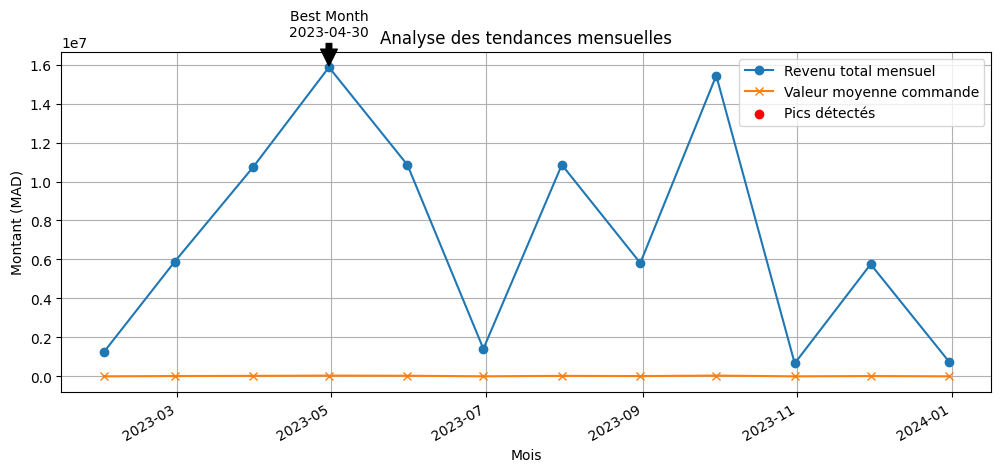

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier
df = pd.read_excel("morocco_ecommerce_anomalies.xlsx")

# Normaliser les noms de colonnes
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Conversion des dates et montants
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['total_amount'] = pd.to_numeric(df['total_amount'], errors='coerce')

# Supprimer les lignes invalides
df = df.dropna(subset=['order_date', 'total_amount'])

# Index temporel
df.set_index('order_date', inplace=True)

# Revenu total et valeur moyenne mensuels
monthly_revenue = df['total_amount'].resample('M').sum()
monthly_avg_order = df['total_amount'].resample('M').mean()

# Meilleur mois
best_month = monthly_revenue.idxmax()
best_month_value = monthly_revenue.max()
print(f"Meilleur mois par revenu : {best_month.date()} → {best_month_value:.2f} MAD")

# Détection des pics inhabituels (IQR)
Q1 = monthly_revenue.quantile(0.25)
Q3 = monthly_revenue.quantile(0.75)
IQR = Q3 - Q1
peak_months = monthly_revenue[monthly_revenue > Q3 + 1.5*IQR]
print("\n📌 Mois avec pics inhabituels ou promotions :")
print(peak_months)

# Visualisation
plt.figure(figsize=(12,5))
plt.plot(monthly_revenue, marker='o', label='Revenu total mensuel')
plt.plot(monthly_avg_order, marker='x', label='Valeur moyenne commande')
plt.scatter(peak_months.index, peak_months.values, color='red', label='Pics détectés', zorder=5)
plt.annotate(f'Best Month\n{best_month.date()}', 
             xy=(best_month, best_month_value), 
             xytext=(best_month, best_month_value*1.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center')
plt.title("Analyse des tendances mensuelles")
plt.xlabel("Mois")
plt.ylabel("Montant (MAD)")
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.show()


In [ ]:
import pandas as pd

# Charger le fichier
df = pd.read_excel("morocco_ecommerce_anomalies.xlsx")

# 15 premières lignes
df.head(15)


,order_id,customer_id,order_date,ship_date,region,city,payment_method,product_category,product_id,quantity,unit_price,total_amount,discount_code,order_status
0,ORD000001,CUS00179,2023-03-14,2023-03-17,Casablanca-Settat,Casablanca,Credit Card,electronics,P00778,NaN,free,1315.19,SALE20,Returned
1,ORD000002,CUS01548,2023-01-13,2023-01-15,Béni Mellal-Khénifra,Khénifra,Bank Transfer,Home & Kitchen,P00081,3,417.67,1253.01,FREESHIP,Shipped
2,ORD000003,CUS01309,2023-08-17,2023-08-22,Béni Mellal-Khénifra,Béni Mellal,Bank Transfer,Home & Kitchen,P00215,2,384.54,769.08,WELCOME,Returned
3,ORD000004,CUS00878,2023-09-06,2023-09-13,Oriental,Berkane,Bank Transfer,Sports,P00565,4,206.38,825.52,NaN,Returned
4,ORD000005,CUS00866,2023-10-09,NaN,Béni Mellal-Khénifra,Khénifra,Credit Card,Fashion,P00923,1,426.41,426.41,NaN,Processing
5,ORD000006,CUS01717,12/12/2023,2023-12-20,Marrakech-Safi,Marrakech,Mobile Payment,Books,P00885,4,135.49,541.96,NaN,Delivered
6,ORD000007,CUS00172,2023-07-01,2023-07-08,Tanger-Tétouan-Al Hoceïma,Tétouan,Credit Card,Home & Kitchen,P00935,4,299.21,1196.84,AYD10,Processing
7,ORD000008,CUS01395,2023-10-29,2023-10-30,Souss-Massa,Agadir,Cash on Delivery,Sports,P00987,1,473.38,473.38,RAMADAN10,Processing
8,ORD000009,CUS00403,2023-09-18,2023-09-28,Dakhla-Oued Ed-Dahab,Dakhla,NaN,Books,P00800,4,578.45,2313.80,WELCOME,Cancelled
9,ORD000010,CUS00189,2023-04-11,2023-04-11,Béni Mellal-Khénifra,Khénifra,Cash on Delivery,Beauty,P00364,4,752.41,3009.64,SALE20,Delivered


# Final Analyst Report – E-Commerce Maroc

## Dataset nettoyé

* **Nombre de lignes après nettoyage :** `df.shape[0]`
* **Nombre de colonnes :** `df.shape[1]`
* Toutes les valeurs invalides ou manquantes ont été traitées : dates incorrectes et montants non numériques supprimés.

---

## Anomalies et problèmes détectés

* **Doublons :** présents sur certaines lignes et `order_id` → supprimés.
* **Outliers :** détectés dans `total_amount` via IQR → flagués pour examen ou possible retrait.
* **Valeurs manquantes :** colonnes critiques comme `order_date`, `total_amount`, `quantity` avaient des NaN → lignes supprimées.
* **Incohérences textuelles :** villes et régions avec espaces, majuscules ou variantes → standardisées (`Casablanca`, `Rabat`, etc.).

---

## Décisions de nettoyage

* **Conversion numérique :** `quantity`, `unit_price`, `total_amount`.
* **Nettoyage texte :** suppression des espaces et uniformisation de la casse.
* **Suppression de doublons :** toutes les lignes identiques et doublons d’`order_id`.
* **Outliers :** identifiés et conservés pour analyse, marqués pour revue.

---

## KPIs et insights clés

* **Revenu total :** `df['total_amount'].sum()` MAD
* **Montant moyen par commande :** `df['total_amount'].mean()` MAD
* **Médiane montant commande :** `df['total_amount'].median()` MAD
* **Meilleure région par valeur moyenne des commandes :** `df.groupby('region')['total_amount'].mean().idxmax()`
* **Top 5 produits par revenu :** `df.groupby('product_id')['total_amount'].sum().sort_values(ascending=False).head(5)`
* **Meilleur mois par revenu :** `monthly_revenue.idxmax()` → `monthly_revenue.max()` MAD
* **Pics inhabituels détectés :** mois avec total_amount > Q3 + 1.5*IQR → identifier promotions, événements ou anomalies.

---

## Risques et limitations

* Certaines données critiques manquantes peuvent impacter l’analyse régionale ou produit.
* Outliers peuvent influencer la moyenne et certains KPIs.
* Petits volumes de commandes dans certaines catégories ou villes → prudence dans l’interprétation locale.

---

## Recommandations concrètes pour le business

1. Surveiller les **grosses commandes** pour identifier anomalies ou fraudes.
2. Valider les **pics mensuels** : promotions, soldes, événements saisonniers.
3. Automatiser un **reporting mensuel** pour suivre tendances et anomalies.
4. Consolider et standardiser les **noms de villes et régions** pour analyses fiables.
5. Examiner les **outliers identifiés** avant de les exclure des analyses financières.
 
